<a href="https://colab.research.google.com/github/shobhit-saini/Neural_Network/blob/master/communications_from_a_speech_impaired_person_to_someone_who_doesn't_understand_sign_language/code/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

y = 4


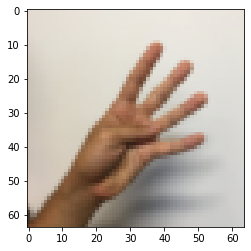

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
def load_dataset():
    #Train Set Dataset
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    #Test set Dataset
    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()
'''
Dims:
train_set_x_orig: (1080, 64, 64, 3)
train_set_y_orig: (1, 1080)
test_set_x_orig: (120, 64, 64, 3)
test_set_y_orig: (1, 120)
flatten_train_set_x: (12288, 1080)
flatten_test_set_y: (12288, 120)
training_output:(6, 1080)
'''

#Analyze the data

plt.imshow(train_set_x_orig[30])
print ("y = " + str(np.squeeze(train_set_y_orig[:, 30])))

#Converting each dataset in column vector
flatten_train_set_x = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
flatten_test_set_x = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
#One hot encoding
training_output = []
for i in train_set_y_orig[:][0]:
  tmp = np.zeros(6)
  tmp[i] = 1.0
  training_output.append(tmp)
training_output = np.array(training_output)
training_output = training_output.T

#Normalize the dataset
flatten_train_set_x = (flatten_train_set_x - flatten_train_set_x.mean(axis = 0))/flatten_train_set_x.std(0)
flatten_test_set_x = (flatten_test_set_x - flatten_test_set_x.mean(axis = 0))/flatten_test_set_x.std(0)

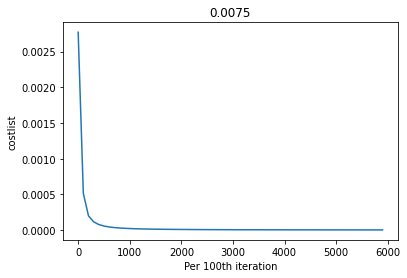

In [8]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
def relu(x):
  return np.maximum(0,x)
def relu_prime(x):
  return np.where(x > 0, 1.0, 0.0)
#Define features of each layer
Input_layer_features = flatten_train_set_x.shape[0]
First_hidden_layer_features = 100
Second_hidden_layer_features = 50
Output_features = 6
m = flatten_train_set_x.shape[1]

#Define Hyperparaameters
learning_rate = 0.0075
#Define parameters
W1 = np.random.randn(First_hidden_layer_features, Input_layer_features)*np.sqrt(2/(Input_layer_features)) #(100, 12288)
W2 = np.random.randn(Second_hidden_layer_features, First_hidden_layer_features)*np.sqrt(2/First_hidden_layer_features)#(50, 100)
W3 = np.random.randn(Output_features, Second_hidden_layer_features)*np.sqrt(1/Second_hidden_layer_features)#(6, 50)
b1 = np.zeros((First_hidden_layer_features, 1))#(100, 1)
b2 = np.zeros((Second_hidden_layer_features, 1))#(50, 1)
b3 = np.zeros((Output_features, 1))#(6, 1)

costlist = []
iteration = []
for i in range(6000):
  Z1 = np.dot(W1, flatten_train_set_x) + b1 #(100, 1080) one column signifies value of Z1 due to one training example
  A1 = relu(Z1)
  Z2 = np.dot(W2, A1) + b2#(50, 1080) 
  A2 = relu(Z2)
  Z3 = np.dot(W3, A2) + b3 #(6, 1080)
  A3 = softmax(Z3)
  '''__________________________Loss_Calculation_________________________________'''
  loss = 0
  if i%100 == 0:
    loss = -np.sum(np.multiply(training_output, np.log(A3)) + np.multiply((1-training_output), np.log(1-A3)))/m
    costlist.append((loss/m))
    iteration.append(i)
  '''_________________________Back_Propagation__________________________________'''
  dZ3 = A3-training_output
  assert( dZ3.shape == Z3.shape )
  dW3 = np.dot(dZ3, A2.T)/m
  assert( dW3.shape == W3.shape )
  db3 = np.sum(dZ3, axis = 1, keepdims= True)/m
  assert( db3.shape == b3.shape )
  dA2 = np.dot(W3.T, dZ3)#(50,6)*(6, 1080) = (50, 1080)
  assert( dA2.shape == A2.shape )
  dZ2 = np.multiply(dA2, relu_prime(Z2))
  assert(dZ2.shape == Z2.shape)
  dW2 = np.dot(dZ2, A1.T)/m
  assert(dW2.shape == W2.shape)
  db2 = np.sum(dZ2, axis = 1, keepdims= True)/m
  assert( db2.shape == b2.shape )
  dA1 = np.dot(W2.T, dZ2)
  assert(dA1.shape == A1.shape)
  dZ1 = np.multiply(dA1, relu_prime(Z1))
  assert(dZ1.shape == Z1.shape)
  dW1 = np.dot(dZ1, flatten_train_set_x.T)/m
  assert(dW1.shape == W1.shape)
  db1 = np.sum(dZ1, axis = 1, keepdims= True)/m
  assert(db1.shape == b1.shape)

  '''__________________________Update_Parameters________________________________'''
  W1 -= learning_rate*dW1
  W2 -= learning_rate*dW2
  W3 -= learning_rate*dW3
  b1 -= learning_rate*db1
  b2 -= learning_rate*db2
  b3 -= learning_rate*db3

plt.plot(iteration, costlist)
plt.xlabel("Per 100th iteration")
plt.ylabel("costlist")
plt.title(learning_rate)
plt.show()


In [12]:
def training_set_accuracy():
  Z1 = np.dot(W1, flatten_train_set_x) + b1 #(100, 1080) one column signifies value of Z1 due to one training example
  A1 = relu(Z1)
  Z2 = np.dot(W2, A1) + b2 #(50, 1080) 
  A2 = relu(Z2)
  Z3 = np.dot(W3, A2) + b3 #(6, 1080)
  A3 = softmax(np.array(Z3,dtype=np.float128))
  out = np.argmax(A3,axis = 0)
  count = 0
  for i in range(1080):
    if out[i] == train_set_y_orig[0][i]:
      count = count + 1;
  print( "Number of training example correctly identified out of 1080:",count )
  accuracy = 100 - ((1080 - count)/m)*100 
  print( "Training Accuracy:", accuracy )
def test():
  Z1 = np.dot(W1, flatten_test_set_x) + b1 #(100, 1080) one column signifies value of Z1 due to one training example
  A1 = relu(Z1)
  Z2 = np.dot(W2, A1) + b2 #(50, 1080) 
  A2 = relu(Z2)
  Z3 = np.dot(W3, A2) + b3 #(6, 1080)
  A3 = softmax(np.array(Z3,dtype=np.float128))
  out = np.argmax(A3,axis = 0)
  count = 0
  for i in range(120):
    if out[i] == test_set_y_orig[0][i]:
      count = count + 1;
  print("Number of test examples correctly identified out of 120:", count)
  accuracy = 100 - ((120 - count)/120)*100 
  print( "Test Accuracy:", accuracy )
training_set_accuracy()
test()


Number of training example correctly identified out of 1080: 1080
Training Accuracy: 100.0
Number of test examples correctly identified out of 120: 114
Test Accuracy: 95.0
